In [1]:
# export
import torch
import torch.nn as nn
from fastai.vision.all import *
from fastai.data.all import *
from IPython.display import display, clear_output
import pandas as pd
import numpy as np
from pathlib import Path
import time
import torchvision.transforms as T
import cv2

# Reading the data 

In [2]:
eugenio = True
path_charades = Path('/mnt/data/eugeniomarinelli/videodata') if eugenio else Path('/mnt/data/adrianlopez/Videos/Charades') 

df = pd.read_csv(path_charades/f'df.csv', index_col=0)
vid_as_series = df.loc[0]

In [3]:
#export
def show_frames(video,start=0, end=5):
    '''show frames in a video from start to end'''
    for frame in video[start:end]:
        clear_output(wait=True)
        frame.show()
        time.sleep(0.5)

In [16]:
vid_as_paths = L(vid_as_series.paths.split('\n'))
vid_as_paths = L(path_charades.parent/path for path in vid_as_paths)
vid_as_paths

(#223) [Path('/mnt/data/eugeniomarinelli/videodata/Charades_v1_rgb/46GP8/46GP8-000286.jpg'),Path('/mnt/data/eugeniomarinelli/videodata/Charades_v1_rgb/46GP8/46GP8-000287.jpg'),Path('/mnt/data/eugeniomarinelli/videodata/Charades_v1_rgb/46GP8/46GP8-000288.jpg'),Path('/mnt/data/eugeniomarinelli/videodata/Charades_v1_rgb/46GP8/46GP8-000289.jpg'),Path('/mnt/data/eugeniomarinelli/videodata/Charades_v1_rgb/46GP8/46GP8-000290.jpg'),Path('/mnt/data/eugeniomarinelli/videodata/Charades_v1_rgb/46GP8/46GP8-000291.jpg'),Path('/mnt/data/eugeniomarinelli/videodata/Charades_v1_rgb/46GP8/46GP8-000292.jpg'),Path('/mnt/data/eugeniomarinelli/videodata/Charades_v1_rgb/46GP8/46GP8-000293.jpg'),Path('/mnt/data/eugeniomarinelli/videodata/Charades_v1_rgb/46GP8/46GP8-000294.jpg'),Path('/mnt/data/eugeniomarinelli/videodata/Charades_v1_rgb/46GP8/46GP8-000295.jpg')...]

# Defining the Video Class

In [17]:
#export
@patch 
def insert(l:L, i, o):
    l.items.insert(i, o)

class Video(L):
    @classmethod
    def create(cls, paths, sep='\n'): 
        '''create images from frames path in a video'''
        paths = paths.split(sep) if isinstance(paths, str) else paths
        return cls(map(PILImage.create, paths))
    
    def show(self, i=None):
        if i == None: i = random.randint(0, len(self))
        self[i].show()        
            
    def __mul__(self, n):
        neg = n < 0
        if n==0 or abs(n) >=1: return self[[(i+neg)//n for i in range(abs(int(n))*len(self))]]
        else: return self/(1/n)
        
    def __truediv__(self, n):
        n = int(n)
        return self[::n]
    
    def __rmul__(self, n):
        return self*n
    
    def __getitem__(self, idx): return self._get(idx) if is_indexer(idx) else Video(self._get(idx), use_list=None)      
    

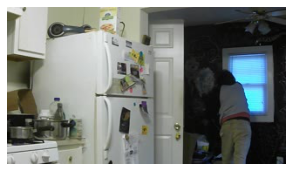

In [18]:
vid_as_imgs = Video.create(vid_as_paths)
vid_as_imgs.show()

# Transforms of the video pipeline 

In [20]:
#export
def snippets_from_video(vid, l=10, s=2):
    '''create list of snippet out a video'''
    vid=vid[::s] # skip frames
    return [Video([vid[i] for i in range(k*l, k*l + l)]) for k in range(0,len(vid)//l)]
        
def stretch(vid, l):
    vid = vid*(l//len(vid))
    if len(vid) == l: return vid
    lv = len(vid)
    n = l - lv                     # Number of frames to be inserted
    d = lv//n                      # Number of frames between inserted frames
    idxs = L(range(lv))
    for i in range(n):
        idxs.insert((d+1)*i, d*i)
    return vid[idxs]

class ResizeTime(Transform):
    split_idx = None # 0- train 1- validation 
    def __init__(self, skip=2, l=50, drop_last=True,**kwargs): 
        self.skip = skip
        self.l = l
        self.drop_last = drop_last
        super().__init__(**kwargs)
        
    def encodes(self, vid:Video, split_idx=split_idx):
        '''create a list of frame-images (snippet) out a single video path'''
        l, skip, l_vid = self.l, self.skip, len(vid)
        if l_vid > l*skip:
            snippet_list = snippets_from_video(vid,s=skip,l=l)
            idx = len(snippet_list)//2 if split_idx else random.randint(0,len(snippet_list)-1) # ** if validation always takes middle snip
            return snippet_list[idx]     
        else:
            vid = vid[::skip]
            vid = stretch(vid, l)         
        return vid

In [24]:
test_eq(len(ResizeTime(50)(vid_as_imgs)), 50)

In [25]:
#export
class TensorVideo(TensorBase): pass

@ToTensor
def encodes(self, vid:Video):
    return TensorVideo(vid.stack().permute(3,0,1,2))

In [60]:
#export
@Resize
def encodes(self, video:Video):
    return video.map(partial(Resize.encodes[PILImage], self))

In [64]:
vid_resized = Resize(224, method=ResizeMethod.Pad)(np.random.randn(3,260,320))
vid_resized[0].shape

(260, 320)

In [29]:
#export
class TensorVideo(TensorBase):
    def show(self, i=None):
        if i == None: i = random.randint(0, len(self))
        TensorImage(self[:,i]).show()
            
@ToTensor
def encodes(self, vid:Video):
    return TensorVideo(vid.stack().permute(3,0,1,2))

@Resize
def encodes(self, video:TensorVideo):
    return T.Resize(self.size)(video)

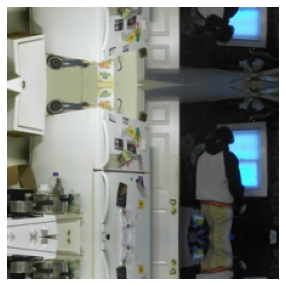

In [41]:
vid_tensor = ToTensor()(vid_resized)
vid_tensor.show()

In [68]:
T.Resize(128,128)(tensor(vid_tensor)).shape

ValueError: This interpolation mode is unsupported with Tensor input

In [48]:
#export
@IntToFloatTensor
def encodes(self, vid:TensorVideo):
    return vid.float()/self.div if vid.dtype==torch.uint8 else vid

In [50]:
IntToFloatTensor()(vid_tensor).max()

TensorVideo(1.)

# Uniformizing the dataset 

In [52]:
#export
def uniformize_dataset(items, lbls, vocab=None, n_el=3, n_lbl=3, shuffle=True):
    if vocab is None: vocab = list(set(lbls))
    lbl2idxs = {lbl:[] for lbl in vocab}
    for i, lbl in enumerate(lbls): lbl2idxs[lbl].append(i)
    for lbl, idxs in lbl2idxs.items(): 
        if len(idxs) < n_el: vocab.remove(lbl)       
    if shuffle: [random.shuffle(v) for v in lbl2idxs.values()]
    idxs = []
    while len(vocab) >= n_lbl:
        lbl_samples = random.sample(vocab, n_lbl)
        for lbl in lbl_samples:
            i = 0
            while i < n_el:
                i += 1
                idx = lbl2idxs[lbl].pop()
                idxs.append(idx)
            if len(lbl2idxs[lbl]) <= n_el:
                vocab.remove(lbl)
    return [items[idx] for idx in idxs] if isinstance(items, list) else getattr(items, 'iloc', items)[idxs]

In [53]:
items = pd.read_csv(path_charades/'df0.csv', index_col=0)
items = uniformize_dataset(items, items['lbl'])
items.tail(6)

,id,coded_lbl,lbl,start,end,val
25701,2EPFZ,c059,Sitting in a chair,13.3,32.2,False
62995,5SBEY,c059,Sitting in a chair,10.7,16.0,True
36955,ICXAE,c059,Sitting in a chair,0.0,13.4,False
60644,1KC11,c154,Someone is standing up from somewhere,27.6,32.1,True
12697,G9JMG,c154,Someone is standing up from somewhere,19.5,24.7,False
54745,1LBUG,c154,Someone is standing up from somewhere,29.5,32.0,True


In [55]:
lbls = list(items['lbl'])
uniformize_dataset(lbls, lbls)[-5:]

['Walking through a doorway',
 'Walking through a doorway',
 'Someone is standing up from somewhere',
 'Someone is standing up from somewhere',
 'Someone is standing up from somewhere']

In [58]:
#export
class UniformizedShuffle():
    def __init__(self, lbls, vocab=None, n_el=4, n_lbl=4):
        self.lbls = lbls
        if vocab is None: vocab = list(set(lbls))
        self.vocab = vocab
        self.n_el = n_el
        self.n_lbl = n_lbl
    def __call__ (self, items):
        return uniformize_dataset(items, lbls=self.lbls.copy(), vocab=self.vocab.copy(), n_el=self.n_el, n_lbl=self.n_lbl)

In [59]:
df = pd.read_csv(path_charades/'df0.csv', index_col=0)
un = UniformizedShuffle(items['lbl'])
un(items).tail(7)

,id,coded_lbl,lbl,start,end,val
29646,67EEN,c154,Someone is standing up from somewhere,12.8,18.7,False
6672,IYVVM,c154,Someone is standing up from somewhere,19.2,24.2,False
49543,O03Y4,c154,Someone is standing up from somewhere,0.0,17.0,False
35697,NWFOF,c097,Walking through a doorway,19.8,26.6,False
57649,FTYFA,c097,Walking through a doorway,0.0,4.9,True
59413,KCRQU,c097,Walking through a doorway,0.8,6.5,True
10909,O18DS,c097,Walking through a doorway,0.0,11.6,False


In [11]:
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_triplet_loss.ipynb.
Converted 04_experiments_on_images.ipynb.
Converted 05_inflator.ipynb.
Converted 06_video_block.ipynb.
Converted 07_read_video_function.ipynb.
Converted 08_charades.ipynb.
Converted 09_ucf.ipynb.
Converted 10_distributed_inflated_NN.ipynb.
Converted 11_transformer.ipynb.
Converted 12_lr_schedule.ipynb.
Converted CreateEmbeddings.ipynb.
Converted Experiments_on_images.ipynb.
Converted index.ipynb.


In [5]:
# default_exp video_block